In [1]:
%%HTML
<link rel="stylesheet" href="presentazione.css" type="text/css" />

In [2]:
import os
import numpy as np
import pandas as pd
import locale
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL

%matplotlib inline

plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style = 'whitegrid', font_scale = 1.2)

locale.setlocale(locale.LC_TIME, 'it_IT.utf8')

pd.set_option('display.max_rows', 5)

<div class="logo-container">
    <img class="uni-logo" src="imgs/presentazione/pollo.jpg"/>
    <span class="testatina">Università degli Studi di Udine</span>
</div>


    
Progetto di Fondamenti di Scienze dei Dati
    
# Analisi dei corrispettivi dell'azienda *Là di Cjastelan*
    
Dario Gaudiuso - 15 luglio 2025

# Introduzione

## L'azienda

<img src="imgs/presentazione/logo.png" id="logo">

- Piccola azienda agricola di S. Osvaldo, Udine a conduzione famigliare
- In attività storicamente dal 1870, dal 2007 nella forma attuale

### I prodotti

<ul id="prodotti-carousel">
    <li class="reset">
        <img src="imgs/presentazione/budino-cioccolato.jpeg" />
        <img src="imgs/presentazione/yogurt.JPG" />
    </li>
    <li class="reset">
        <img src="imgs/presentazione/cac_peperoncino2.JPG" />
        <img src="imgs/presentazione/salame.jpeg" />
    </li>
    <li class="reset">
        <img src="imgs/presentazione/mozzarella.jpeg" />
        <img src="imgs/presentazione/carne_maiale.jpeg" />
    </li>
    <li class="reset">
        <img src="imgs/presentazione/salsiccia.jpeg" />
        <img src="imgs/presentazione/ricotta.JPG" />
    </li>
</ul>

### I mercati

<img src="imgs/presentazione/bancarella.jpeg" id="img-bancarella"/>


### e le persone

<img src="imgs/presentazione/trattori.jpeg" />

## I dati

### I corrispettivi

L'Agenzia delle Entrate richiede che ogni trimestre venga consegnata un'autocertificazione riguardo **i corrispettivi** dei registratori di cassa telematici.

**Per ogni cassa** usata dall'azienda, bisogna dichiarare **per ogni giorno** il **totale** incassato in **ciascuna categoria di aliquota IVA**.

I prodotti venduti dall'azienda ricadono in **4 categorie**:
- **IVA 4%** -> Prodotti agricoli (latte, latticini e formaggi)
- **IVA 10% agricola** -> Carne, insaccati e yogurt
- **IVA 10% commerciale** -> Trasformati (gelato, budini, dessert, frico, tortelli, ragù...)
- **IVA 22%** -> Beni non agricoli (buste, confezioni...)

### Come sono raccolti i corrispettivi

<div class="reset" id="corrispettivo-wrapper">
    <div class="reset col1">
        <img class="reset" src="imgs/presentazione/corrispettivo.jpeg">
        <a href="https://www.flaticon.com/free-icons/cow" title="cow icons">Cow icons created by surang - Flaticon</a>
    </div>

  <ul class="reset">
      <li>fino al <strong>2017</strong> una singola persona compilava un'<strong>autodichiarazione cartacea</strong>, sommando manualmente tutti gli scontrini</li>
      <li>da <strong>gennaio 2018</strong> ad <strong>aprile 2024</strong> l'autodichiarazione viene consegnata in <i>pdf</i>, esportando <strong>fogli elettronici</strong> (Excel) in cui vengono ricopiati manualmente i corrispettivi da una singola persona</li>
  </ul>
</div>



da **aprile 2024** a oggi si esporta sempre il solito modello Excel, ma con l'ausilio di un **Google Form**, compilato da chi ha svolto il mercato (il processo però **resta manuale**)

<img src="imgs/presentazione/gform.jpeg" id="img-gform" />

### I reparti

Sono suddivisioni del corrispettivo decise internamente dall'azienda. Nel nostro caso, tutte le casse hanno gli stessi **5 reparti**:
- **Reparto 1** -> Formaggi e latticini
- **Reparto 2** -> Carne e insaccati
- **Reparto 3** -> Yogurt
- **Reparto 4** -> Trasformati
- **Reparto 5** -> Altro (non agricolo)

### Perché studiarli?

Studiare i corrispettivi giornalieri, nella forma in cui sono raccolti, ci permetterebbe di indagare l'**andamento complessivo dell'azienda**, rispondendo a domande come:
1. L'azienda è in crescita o meno?
2. C'è stagionalità nelle vendite, cioè ci sono periodi in cui si vende meglio?
3. Quali prodotti portano più entrate?

Da **aprile 2024** abbiamo anche disponibile l'informazione su **ciascun mercato**, il che, oltre a permetterci di studiare le caratteristiche dei mercati stessi, ci permette di fare **analisi comparate** per capire se:

4. Ci sono mercati che vanno meglio degli altri?
5. Ci sono prodotti che si vendono meglio su un mercato, rispetto agli altri?

# Importazione e pulizia dei dati

## Materiale di partenza

### Cosa è stato consegnato

I dati originali sono stati consegnati in **due forme**:
- una decina di file Excel
- un link a un foglio risposte Google nel Google Drive dell'azienda

I **fogli Excel** coprono tutto l'arco **dal 2018 al primo trimestre del 2025**, ma manca il file dell'ultimo trimestre del 2024.

Il **foglio risposte** registra tutti i corrispettivi da **aprile 2024 a oggi**.

### Fogli Excel

I file sono formati da diversi fogli, uno per mese.

Alcuni file raccolgono i corrispettivi di un intero anno solare (12 fogli, dal 2018 al 2023), altri invece sono organizzati per trimestri dello stesso anno (3 fogli, dal 2024 in poi).

<img src="imgs/presentazione/modello.png" id="img-modello"/>

### Struttura dei fogli Excel

Sebbene l'idea di base sia rimasta la medesima, di fatto **la struttura dei fogli cambia** leggermente sia di file in file, che tra i fogli di uno stesso file.

Questo, per esempio, è il file del **2018**:
<img src="imgs/presentazione/2018.png" />

Questo invece è il file del primo trimestre del **2025**:
<img src="imgs/presentazione/2025.png" />

### Foglio risposte

<img src="imgs/presentazione/foglio-risposte.png" id="img-foglio-risposte" />

## Importazione

### Che forma dare ai dati?

Il dataset è vivo, ma per questa analisi raccogliamo i corrispettivi solo **fino a maggio 2025**.

Riuniamo tutti i dati in un unico *dataframe*, conservando l'informazione a **grana più fine**, cioè tenendo sulle colonne i reparti e non l'IVA.

Sulle **colonne** usiamo un _MultiIndex_ che associa a ciacuna delle 3 casse i propri 5 reparti.

Come **indice** usiamo un *DateTimeIndex* con la data del giorno del corrispettivo.

**Non** importiamo i **totali**:
- sono dati derivati
- alcuni sono sicuramente errati
- mancano per i dati più recenti
 

Costruiamo anche un secondo *dataframe* con informazione sui **mercati**, partendo dal foglio risposte.

In questo caso, manteniamo la struttura del file originale, scartando le colonne di controllo e quelle derivate.

Come **colonne** abbiamo quindi cassa, data, mercato e reparti.

In questo _dataframe_, l'indice non è significativo.

### Dati duplicati

I dati **da aprile 2024** in poi sono (quasi tutti) duplicati: esistono in versione "originale" nel foglio risposte e in versione aggregata nei file Excel. Quali dati importiamo?

Inizialmente sembrava più comodo importare direttamente i dati già pronti nei file Excel e costruire solamente i cinque mesi mancanti partendo dal foglio risposte.

Poi in fase di analisi dei mercati sono emersi **errori e incongruenze** nei dati del foglio risposte, che si erano tramandati nei file Excel.

Quindi i fogli Excel sono stati usati solo fino a **marzo 2024**, da lì in poi i corrispettivi sono stati ricostruiti partendo dalla versione pulita e corretta del dataframe del foglio risposte.

### Pulizia dei dati del foglio risposte

L'integrità dei dati è stata controllata facendo, in ordine, questi controlli:

1. corrispettivi duplicati (anche inseriti come mercati diversi)
2. date scritte in modo sbagliato
3. date incoerenti:
    - scontrini "del futuro": la data inserita dall'utente è successiva al timestamp dell'inserimento
    - mercati impossibili: corrispettivi associati a giorni in cui non c'è il mercato a cui si riferiscono (ma potrebbe essere perché è stato spostato il mercato)
4. vincolo di chiave primaria cassa-mercato
5. totale disallineato con la colonna di controllo
6. verifiche puntuali fatte in fase di analisi

In totale sono state corrette 46 entry su 461 (quasi il 10%)

### Processo di importazione

Per il *dataframe* dei corrispettivi, il processo di importazione è stato sostanzialmente:
- costruire la data completa, ricavando anno e mese dai nomi dei file e dei fogli
- mappare le colonne dei file Excel con i giusti reparti
- aggiungere i dati mancanti prendendoli dal _dataframe_ dei mercati
- eliminare le righe vuote (cioè i giorni senza mercati)
- creare l'indice e ordinarlo

Le principali **difficoltà** affrontate sono state:
- colonne con lo stesso nome ma con significato diverso (per esempio le colonne `IVA 10`)
- mutamento del nome delle colonne
- ordine delle colonne non rigido
- Presenza desultoria della multicolonna `Cassa 3`

## Risultato finale

*Dataframe* dei corrispettivi:

In [3]:
corrispettivi = pd.read_pickle(os.path.join('.', 'data', 'corrispettivi_clean.pickle'))
display(corrispettivi)

Cassa 1                                           Cassa 2  \
           Reparto 1 Reparto 2 Reparto 3 Reparto 4 Reparto 5 Reparto 1   
Data                                                                     
2018-01-02    267.02     57.07       0.0       0.0       0.0      0.00   
2018-01-03    161.85     74.85       0.0       0.0       0.0      0.00   
...              ...       ...       ...       ...       ...       ...   
2025-05-29    104.84     57.62      40.0      20.0       0.0    145.00   
2025-05-31    331.05     35.70       5.1      31.0       0.0    395.83   

                                                     Cassa 3            \
           Reparto 2 Reparto 3 Reparto 4 Reparto 5 Reparto 1 Reparto 2   
Data                                                                     
2018-01-02      0.00      0.00       0.0       0.0       0.0       0.0   
2018-01-03      0.00      0.00       0.0       0.0       0.0       0.0   
...              ...       ...       ...       ...       ...       ...   
2025-05-29     55.84     13.65      14.2       0.0       0.0       0.0   
2025-05-31     22.10     30.25      34.2       0.0       0.0       0.0   

                                          
           Reparto 3 Reparto 4 Reparto 5  
Data                                      
2018-01-02       0.0       0.0       0.0  
2018-01-03       0.0       0.0       0.0  
...              ...       ...       ...  
2025-05-29       0.0       0.0       0.0  
2025-05-31       0.0       0.0       0.0  

[2118 rows x 15 columns]

*Dataframe* dei mercati:

In [4]:
mercati = pd.read_pickle(os.path.join('.', 'data', 'web_clean.pickle'))
display(mercati)

,Data,Cassa,Mercato,Reparto 1,Reparto 2,Reparto 3,Reparto 4,Reparto 5
0,2024-04-02,Cassa 2,Centro - Martedì,116.90,46.00,3.3,7.23,NaN
1,2024-04-02,Cassa 1,Passons - Martedì,150.97,14.07,20.6,41.74,NaN
...,...,...,...,...,...,...,...,...
459,2025-06-10,Cassa 2,Passons - Martedì,132.22,31.57,32.4,39.70,NaN
460,2025-06-11,Cassa 2,Villaggio - Mercoledì,240.02,26.54,27.1,NaN,NaN


# Analisi

## I corrispettivi

### Serie temporale
Visualizziamo la serie storica, aggregando i corrispettivi delle tre casse nel corrispettivo totale giornaliero.

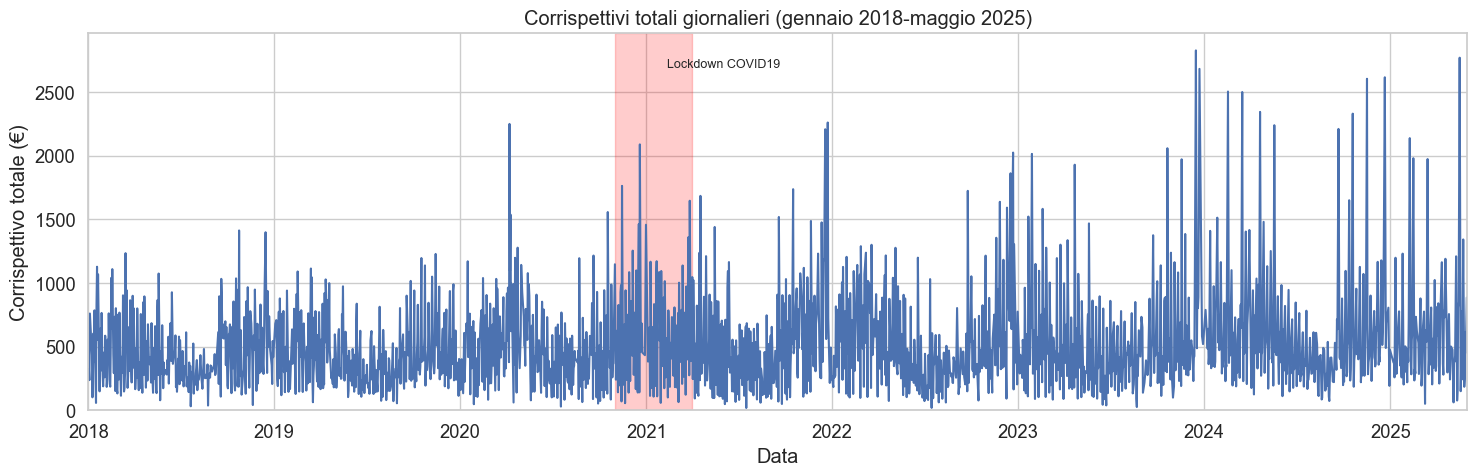

In [5]:
corrispettivi_tot = corrispettivi.sum(axis=1)

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(corrispettivi_tot)
ax.set_title('Corrispettivi totali giornalieri (gennaio 2018-maggio 2025)')

# mostro il periodo covid (novembre 2020-aprile 2021)
ax.axvspan(pd.to_datetime('2020-11-1'), pd.to_datetime('2021-4-1'), color='red', alpha=0.2)
ax.text(pd.to_datetime('2021-6-1'), ax.get_ylim()[1] * 0.9, 'Lockdown COVID19', ha='center', va='bottom', fontsize='9')

ax.set_xlim(pd.to_datetime('2018-1-1'), pd.to_datetime('2025-5-31'))
ax.set_ylabel('Corrispettivo totale (€)')
ax.set_ylim(0, None)

plt.tight_layout()
plt.show()

Riusciamo a intuire:
 - una **stagionalità mensile**
 - un **andamento stazionario** ma con picchi in crescita

### Stagionalità

Usiamo i **grafici stagionali** per verificare visivamente se c'è stagionalità nei dati.

Indaghiamo la presenza di:
- un **periodo stagionale mensile**
- un **periodo stagionale annuale**

In [6]:
stagionale = corrispettivi.copy()
stagionale['Corrispettivo totale (€)'] = stagionale.sum(axis=1)
stagionale = stagionale[['Corrispettivo totale (€)']]
stagionale.to_csv('../stagionale.csv')
stagionale['Anno'] = stagionale.index.year
stagionale['Giorno anno'] = stagionale.index.day_of_year
stagionale['Mese-anno'] = stagionale.index.strftime('%b%y')
stagionale['Giorno'] = stagionale.index.day
stagionale

,Corrispettivo totale (€),Anno,Giorno anno,Mese-anno,Giorno
,,,,,
Data,,,,,
2018-01-02,324.09,2018,2,gen18,2
2018-01-03,236.70,2018,3,gen18,3
...,...,...,...,...,...
2025-05-29,451.15,2025,149,mag25,29
2025-05-31,885.23,2025,151,mag25,31


### Stagionalità mensile

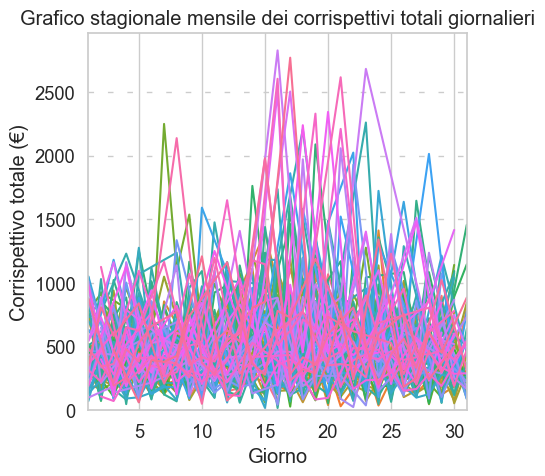

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(stagionale, x='Giorno', y='Corrispettivo totale (€)', hue='Mese-anno', legend=False)
ax.set_title('Grafico stagionale mensile dei corrispettivi totali giornalieri')

ax.set(xlim=(1, 31), ylim=(0, None))
ax.grid(axis='y', linestyle=(0, (4, 10)))
plt.tight_layout()
plt.show()

Non emerge nessun pattern evidente

### Stagionalità annuale

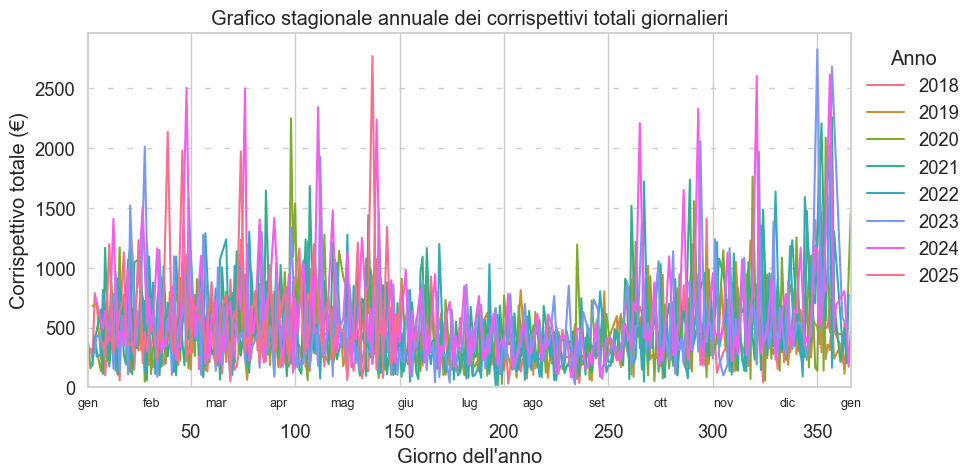

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(stagionale, x='Giorno anno', y='Corrispettivo totale (€)', hue='Anno', palette='husl', legend='full')
ax.set_title('Grafico stagionale annuale dei corrispettivi totali giornalieri')

ax.set(
    xlabel="Giorno dell'anno",
    xlim=(1, 366),
    ylim=(0, None)
)

ax.set_xticks(
    np.linspace(1, 366, 13), minor=True,
    labels=[d.strftime('%b') for d in pd.date_range('2024-01-01', '2025-1-1', freq='MS')],
    fontsize=9
)
ax.tick_params(axis='x', which='major', pad=20)

ax.grid(axis='y', linestyle=(0, (4, 10)))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

Emerge chiaramente un pattern stagionale che vede **una flessione** da giugno a ottobre e **un picco** a dicembre

### Funzione di autocorrelazione e correlogramma

Calcoliamo la ACF usando la libreria `statsmodel`. Il numero di ritardi è $k = 10log(T)$ mentre la soglia di significatività è calcolata come $\alpha = \pm 1.96\sqrt T$, con $T$ lunghezza della serie.

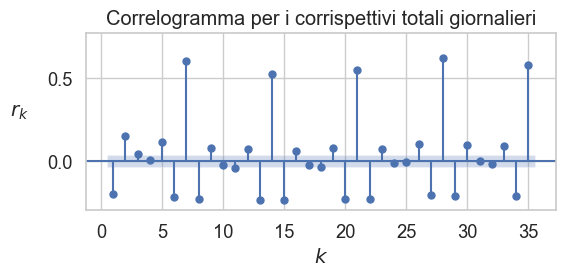

In [9]:
# l'ACF necessita degli 0 sui giorni senza mercati
corr_tot_filled = corrispettivi_tot.resample('D').mean().fillna(0)

fig, ax = plt.subplots(figsize=(6, 3))
plot_acf(corr_tot_filled,
         ax=ax,
         zero=False, bartlett_confint=False, auto_ylims=True)

ax.set_title("Correlogramma per i corrispettivi totali giornalieri")
ax.set_ylabel(r"$r_k$", rotation=0, labelpad=20)
ax.set_xlabel(r"$k$")

plt.tight_layout()
plt.show()

La forma del correlogramma conferma la prevalenza della componente stagionale nei dati rispetto alla componente trend e individua come periodo stagionale 7 giorni, suggerendo una stagionalità settimanale e confermando che **non c'è stagionalità mensile**.

Per far emergere la **stagionalità annuale**, dobbiamo calcolare la ACF ricampionando i dati mensilmente: passiamo dai totali giornalieri ai totali mensili.

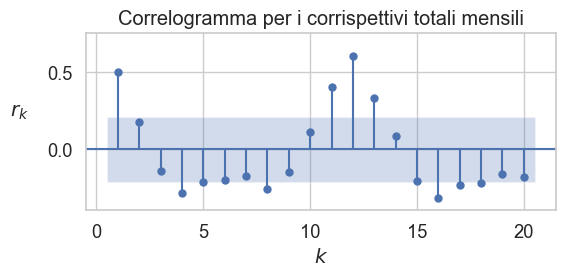

In [10]:
corrispettivi_mensile = corr_tot_filled.resample('MS').sum()
fig, ax = plt.subplots(figsize=(6, 3))
plot_acf(corrispettivi_mensile,
         ax=ax,
         zero=False, bartlett_confint=False, auto_ylims=True)

ax.set_title("Correlogramma per i corrispettivi totali mensili")
ax.set_ylabel(r"$r_k$", rotation=0, labelpad=20)
ax.set_xlabel(r"$k$")

plt.tight_layout()
plt.show()

Anche qui viene individuato come periodo stagionale 12 mesi, **confermando la stagionalità annuale** ipotizzata.

Il valore di $r_1$ indica che mesi successivi correlano molto, suggerendo che non ci sono mai brusche inversioni di tendenza nei dati.
La correlazione negativa di $r_4$ ci informa sul fatto che, di solito, le valli sono a distanza di 4 mesi dai picchi.

### Scomposizione STL

Usiamo il modello STL per effettuare la scomposizione addittiva della serie nelle sue componenti trend, stagionale e residuale. L'implementazione del modello usata è sempre della libreria `statsmodel`, come parametro di lisciamento stagionale si è scelto $n_{(s)}=21$.

In [11]:
stl = STL(corr_tot_filled, robust=True, period=365, seasonal=21)
res_stl = stl.fit()

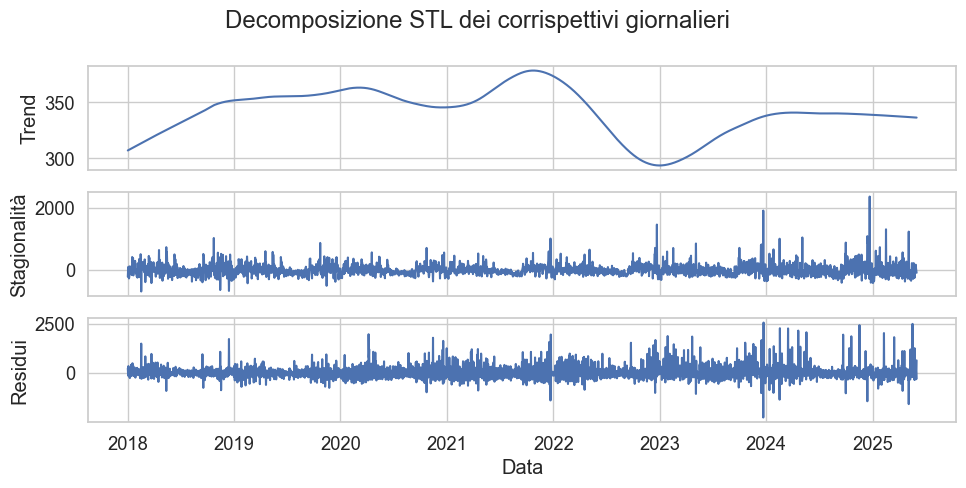

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
fig.suptitle("Decomposizione STL dei corrispettivi giornalieri")

sns.lineplot(res_stl.trend, ax=axes[0])
sns.lineplot(res_stl.seasonal, ax=axes[1])
sns.lineplot(res_stl.resid, ax=axes[2])

axes[0].set_ylabel("Trend")
axes[1].set_ylabel("Stagionalità")
axes[2].set_ylabel("Residui")

fig.subplots_adjust(top=0.90)

plt.tight_layout()
plt.show()

Secondo questa decomposizione, la serie è al momento in una **fase stazionaria**.

L'andamento della componente stagionale, inoltre, sembra cambiare dal 2023, suggerendo che una scomposizione di tipo moltiplicativo sarebbe più adeguata per i dati più recenti, rispetto al modello STL che è di tipo additivo.

### Entrate per categoria di prodotto

L'analisi di questo tipo è, purtroppo, fortemente ostacolata dal fatto che, per alcuni periodi, i corrispettivi del Reparto 3 vengono registrati nel Reparto 2.

Lavoriamo, allora, solo sulla frazione dei dati dove abbiamo la distinzione tra tutti i reparti (57% dei dati raccolti).

In [13]:
reparti = corrispettivi.copy()

reparti = reparti[
    (reparti.index.year == 2020)
    | ((reparti.index.year == 2021) & (reparti.index.month <= 2))
    | ((reparti.index.year == 2022) & (reparti.index.month >= 3))
    | (reparti.index.year >= 2023)
]

# Calcolo i totali dei reparti
reparti_sums = reparti.sum().unstack(level=0)
reparti_sums['Totale'] = reparti_sums.sum(axis=1)
print('Totale dei reparti:')
display(reparti_sums)

# conto quanti scontrini sono stati effettivamente battuti per ciascun reparto
reparti_count = reparti.copy()
reparti_count = (reparti_count > 0).sum().unstack(level=0)
reparti_count['Count'] = reparti_count.sum(axis=1)
print('Conteggio di quanti giorni in totale un reparto compare nel corrispettivo')
display(reparti_count)

reparti_sums['Count'] = reparti_count['Count']
reparti_sums['Prodotto'] = ['Formaggi\ne latticini', 'Carne\ne insaccati', 'Yogurt', 'Gelato, dessert\n e gastronomia', 'Altro\n(non agricolo)']
reparti_sums['Entrata totale (%)'] = reparti_sums['Totale'] / reparti_sums['Totale'].sum() * 100
reparti_sums['Volume totale (%)'] = reparti_sums['Count'] / reparti_sums['Count'].sum() * 100

print('Dataset con i totali di entrate e conteggi')
display(reparti_sums)

reparti_sums_melted = reparti_sums.melt(id_vars='Prodotto', value_vars=['Entrata totale (%)', 'Volume totale (%)'], var_name='Tipo')
print('Stesso dataset massaggiato in forma lunga per poter plottare due serie insieme')
reparti_sums_melted

Totale dei reparti:


,Cassa 1,Cassa 2,Cassa 3,Totale
Reparto 1,243188.20,175873.84,4953.92,424015.96
Reparto 2,89269.45,46951.59,15384.09,151605.13
Reparto 3,18700.01,8681.76,22.30,27404.07
Reparto 4,20487.53,7579.02,0.00,28066.55
Reparto 5,1792.07,1003.26,1040.71,3836.04


Conteggio di quanti giorni in totale un reparto compare nel corrispettivo


,Cassa 1,Cassa 2,Cassa 3,Count
Reparto 1,1011,685,25,1721
Reparto 2,906,568,43,1517
Reparto 3,905,503,2,1410
Reparto 4,631,318,0,949
Reparto 5,24,26,18,68


Dataset con i totali di entrate e conteggi


,Cassa 1,Cassa 2,Cassa 3,Totale,Count,Prodotto,Entrata totale (%),Volume totale (%)
Reparto 1,243188.20,175873.84,4953.92,424015.96,1721,Formaggi\ne latticini,66.781765,30.379523
Reparto 2,89269.45,46951.59,15384.09,151605.13,1517,Carne\ne insaccati,23.877540,26.778464
Reparto 3,18700.01,8681.76,22.30,27404.07,1410,Yogurt,4.316093,24.889673
Reparto 4,20487.53,7579.02,0.00,28066.55,949,"Gelato, dessert\n e gastronomia",4.420432,16.751986
Reparto 5,1792.07,1003.26,1040.71,3836.04,68,Altro\n(non agricolo),0.604170,1.200353


Stesso dataset massaggiato in forma lunga per poter plottare due serie insieme


,Prodotto,Tipo,value
0,Formaggi\ne latticini,Entrata totale (%),66.781765
1,Carne\ne insaccati,Entrata totale (%),23.877540
...,...,...,...
8,"Gelato, dessert\n e gastronomia",Volume totale (%),16.751986
9,Altro\n(non agricolo),Volume totale (%),1.200353


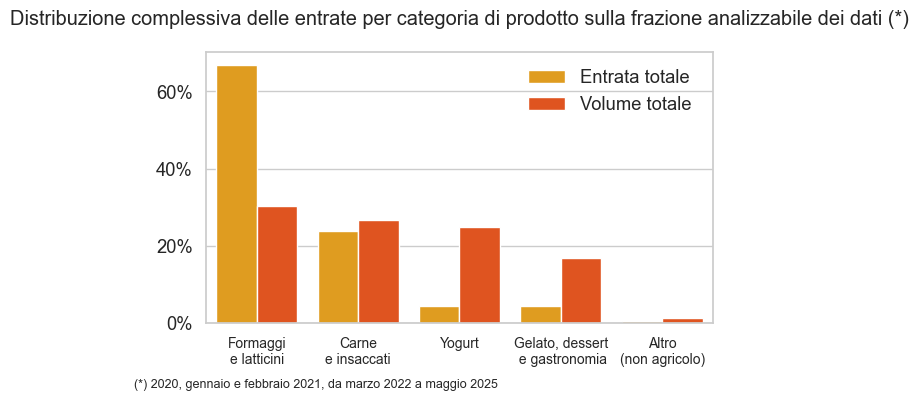

In [14]:
# mia palette custom fatta con ColorBrewer, simile ai colori dell'azienda
barplot_palette = ['orange','orangered','brown']

fig, ax = plt.subplots(figsize=(6, 4))

ax.set_title(
    'Distribuzione complessiva delle entrate per categoria di prodotto sulla frazione analizzabile dei dati (*)',
    pad=20
)

# relativo
sns.barplot(
    reparti_sums_melted, x='Prodotto', y='value', hue='Tipo',
    palette={'Entrata totale (%)': barplot_palette[0], 'Volume totale (%)': barplot_palette[1]}
)

ax.set_ylabel('')
ax.set_xlabel('')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda tick, pos: f'{int(tick)}%'))

ax.tick_params(axis='x', labelsize=10)

# tolgo il titolo e il simbolo % dalla legenda 
handles, labels = ax.get_legend_handles_labels()
labels = [l[:-3] for l in labels]
ax.legend(handles=handles, labels=labels)

fig.text(0, 0, '(*) 2020, gennaio e febbraio 2021, da marzo 2022 a maggio 2025', fontsize=9)

fig.tight_layout()
plt.show()

I prodotti che incidono di più sulle entrate sono di gran lunga formaggi e latticini.

La carne pesa meno di quello che, intuitivamente, saremmo portati a credere, ma comunque ha un grosso peso.

Lo yogurt viene venduto molto di più della gastronomia ma porta meno entrate.

In [15]:
reparti = corrispettivi.copy()

# porto i reparti sulle righe. future_stack sostanzialmente è la nuova implementazione che non chiama dropna e sort
reparti = reparti.stack(future_stack=True).reset_index(1, names=['Data', 'Reparto'])

# teniamo solo gli anni di cui abbiamo dati completi: 2020, 2023 e 2024 e leviamo il reparto 5
reparti['Anno'] = reparti.index.year
reparti = reparti[
    (
        (reparti['Anno'] == 2020)
        | (reparti['Anno'] == 2023)
        | (reparti['Anno'] == 2024)
    ) & (
        reparti['Reparto'] != 'Reparto 5'
    )
]
print('Dataset intermedio: porto i reparti sulle righe')
display(reparti)

rep_per_anno = reparti.pivot_table(index=['Anno', 'Reparto'], aggfunc=['sum', lambda col: (col > 0).sum()])
print('Dataset intermedio ruotato con somma e conteggi')
display(rep_per_anno)

# aggreghiamo le casse, sempre portandole sulle righe
rep_per_anno = rep_per_anno.stack(future_stack=True).groupby(['Anno', 'Reparto']).sum()
tot_per_anno = rep_per_anno.groupby('Anno').sum()
rep_per_anno['Totale %'] = rep_per_anno['sum'] / tot_per_anno['sum'] * 100
rep_per_anno['Volume %'] = rep_per_anno['<lambda>'] / tot_per_anno['<lambda>'] * 100
rep_per_anno.reset_index(inplace=True)

rep_prod_map = {
    'Reparto 1': 'Formaggi\ne latticini',
    'Reparto 2': 'Carne\ne insaccati',
    'Reparto 3': 'Yogurt',
    'Reparto 4': 'Gelato, dessert\ne gastronomia'
}
rep_per_anno['Prodotto'] = rep_per_anno['Reparto'].map(rep_prod_map)


print('Dataset finale con entrate e volumi')
rep_per_anno

Dataset intermedio: porto i reparti sulle righe


,Reparto,Cassa 1,Cassa 2,Cassa 3,Anno
Data,,,,,
2020-01-01,Reparto 1,0.00,367.61,0.0,2020
2020-01-01,Reparto 2,0.00,0.00,0.0,2020
...,...,...,...,...,...
2024-12-31,Reparto 3,3.18,12.70,0.0,2024
2024-12-31,Reparto 4,0.00,39.10,0.0,2024


Dataset intermedio ruotato con somma e conteggi


sum                   <lambda>                
                 Cassa 1   Cassa 2 Cassa 3  Cassa 1 Cassa 2 Cassa 3
Anno Reparto                                                       
2020 Reparto 1  53385.28  64041.97     0.0      203     207       0
     Reparto 2  12363.31   9459.71     0.0      165     154       0
...                  ...       ...     ...      ...     ...     ...
2024 Reparto 3   4938.31   1573.70    22.3      240     113       2
     Reparto 4   7789.03   3122.57     0.0      214     103       0

[12 rows x 6 columns]

Dataset finale con entrate e volumi


,Anno,Reparto,sum,<lambda>,Totale %,Volume %,Prodotto
0,2020,Reparto 1,117427.25,410,80.292598,39.690223,Formaggi\ne latticini
1,2020,Reparto 2,21823.02,319,14.921809,30.880929,Carne\ne insaccati
...,...,...,...,...,...,...,...
10,2024,Reparto 3,6534.31,355,4.466010,25.393419,Yogurt
11,2024,Reparto 4,10911.60,317,7.457759,22.675250,"Gelato, dessert\ne gastronomia"


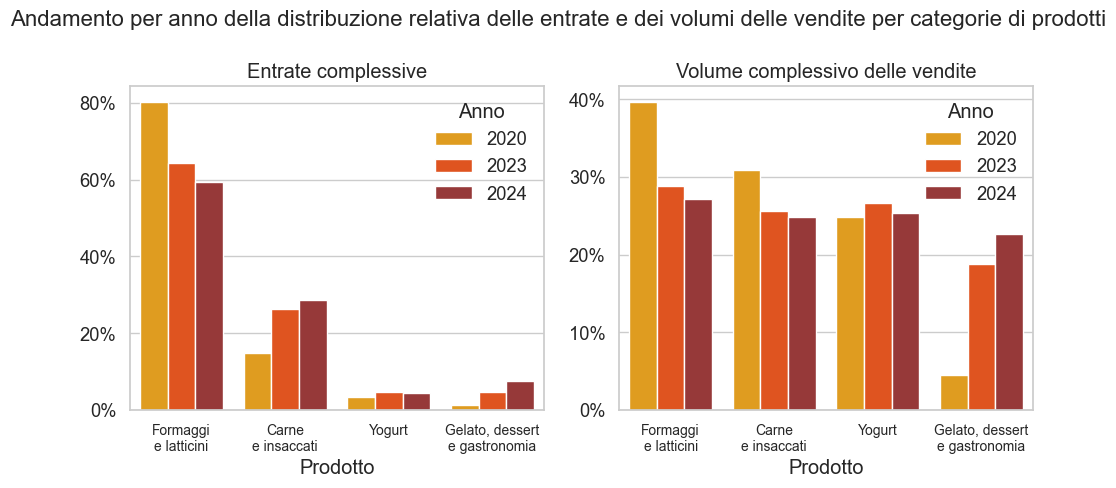

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Andamento per anno della distribuzione relativa delle entrate e dei volumi delle vendite per categorie di prodotti', fontsize=16)
    
# entrate
ax_entrate = axes[0]
sns.barplot(rep_per_anno, x='Prodotto', y='Totale %', hue='Anno', palette=barplot_palette, ax=ax_entrate)
    
ax_entrate.set_title('Entrate complessive')

# volumi
ax_volumi = axes[1]
sns.barplot(rep_per_anno, x='Prodotto', y='Volume %', hue='Anno', palette=barplot_palette, ax=ax_volumi)

ax_volumi.set_title('Volume complessivo delle vendite')

# impostazioni comuni a entrambi i grafici
for ax in axes:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda tick, pos: f'{int(tick)}%'))
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()

La tendenza negli anni vede pesare meno il formaggio e i latticini e più la carne, con la gastronomia in sensibile crescita.

Negli anni la differenza tra i volumi delle vendite si è andata sempre più appiattendo.

## I mercati

Dividiamo i mercati in due categorie:
- i **mercati periodici**, che si svolgono regolarmente ogni settimana
- gli **eventi**, che sono mercati fatti *una tantum* in corrispondenze di fiere o festività

In [17]:
mercati_df = pd.read_pickle(os.path.join('data', 'web_clean.pickle'))
mercati = set(mercati_df['Mercato'].values)
for m in mercati:
    print(m)

Treppo Grande
Centro - Giovedì
Passons - Martedì
Mercoledì Treppo 
S. Osvaldo - Giovedì
Domenica - Oleis
Cormor - Sabato
San pietro
Centro - Martedì
SanPietro
Villaggio
Castello 
Villaggio - Mercoledì
Alveari
San Pietro
Evento vendoglio
Treppo mercoledì 
Osoppo
Coperto - Sabato
Treppo
San pieri
Centro - Sabato
Centro - Lunedì
Castello


In [18]:
# Creiamo un mapping a partire da queste entry
mercati_map = {
    'Treppo mercoledì ': 'Treppo', 
    'S. Osvaldo - Giovedì': 'S. Osvaldo',
    'Passons - Martedì': 'Passons',
    'Centro - Giovedì': 'Centro',
    'Treppo': 'Treppo',
    'Coperto - Sabato': 'Coperto',
    'Evento vendoglio': 'Eventi',
    'Treppo Grande': 'Treppo',
    'San pietro': 'Eventi',
    'Mercoledì Treppo ': 'Treppo', 
    'San Pietro': 'Eventi',
    'San pieri': 'Eventi',
    'Centro - Sabato': 'Centro',
    'Castello': 'Eventi',
    'Centro - Martedì': 'Centro',
    'Villaggio': 'Villaggio',
    'Cormor - Sabato': 'Cormor',
    'Alveari': 'Alveari',
    'Castello ': 'Eventi',
    'Domenica - Oleis': 'Eventi',
    'Villaggio - Mercoledì': 'Villaggio',
    'Osoppo': 'Eventi',
    'SanPietro': 'Eventi',
    'Centro - Lunedì': 'Centro'
}

# controlliamo che tutte le entry abbiano una corrispondenza
for k in mercati_map:
    if k not in mercati:
        print(k)
for k in mercati:
    if k not in mercati_map:
        print(k)
        
mercati_df.rename(columns={'Mercato': 'Mercato originale'}, inplace=True)
mercati_df['Mercato'] = mercati_df['Mercato originale'].map(mercati_map)
mercati_df

,Data,Cassa,Mercato originale,Reparto 1,Reparto 2,Reparto 3,Reparto 4,Reparto 5,Mercato
0,2024-04-02,Cassa 2,Centro - Martedì,116.90,46.00,3.3,7.23,NaN,Centro
1,2024-04-02,Cassa 1,Passons - Martedì,150.97,14.07,20.6,41.74,NaN,Passons
...,...,...,...,...,...,...,...,...,...
459,2025-06-10,Cassa 2,Passons - Martedì,132.22,31.57,32.4,39.70,NaN,Passons
460,2025-06-11,Cassa 2,Villaggio - Mercoledì,240.02,26.54,27.1,NaN,NaN,Villaggio


In [19]:
# Adesso possiamo cominciare ad aggregare
mercati_df['Totale'] = mercati_df.sum(axis=1, numeric_only=True)

print('Indici sintetici delle entrate giornaliere di ciascun mercato:')
pd.set_option('display.max_rows', 20)
mercati_df.groupby('Mercato')['Totale'].describe()

Indici sintetici delle entrate giornaliere di ciascun mercato:


,count,mean,std,min,25%,50%,75%,max
Mercato,,,,,,,,
Alveari,1.0,25.100000,NaN,25.10,25.1000,25.100,25.1000,25.10
Centro,181.0,324.735359,186.604113,49.68,189.1300,282.820,419.0700,1147.60
Coperto,9.0,687.716667,118.870562,480.10,631.5000,674.850,759.6000,863.30
Cormor,56.0,552.053393,250.192625,205.00,382.0200,501.735,661.5350,1190.78
Eventi,12.0,578.155000,321.166789,134.56,345.9275,537.710,813.5675,1146.75
Passons,60.0,333.925333,108.608460,72.66,253.9200,352.505,395.1700,624.74
S. Osvaldo,56.0,296.966071,101.279954,154.94,222.0525,280.250,334.6750,693.22
Treppo,13.0,278.617692,99.891484,97.58,204.6800,264.230,354.1400,451.39
Villaggio,62.0,388.305161,153.379799,174.58,288.8475,362.140,436.9125,985.66


In [20]:
mercati_no_alv = mercati_df[mercati_df['Mercato'] != 'Alveari']
mercati_sintesi = mercati_no_alv.groupby('Mercato')['Totale'].describe().sort_values('std', ascending=False)
mercati_tot = mercati_df.groupby('Mercato').sum(numeric_only=True)
mercati_tot['Totale %'] = mercati_tot['Totale'] / mercati_tot['Totale'].sum() * 100
mercati_tot.sort_values('Totale', ascending=False, inplace=True)

print('Entrata totale di ciascun mercato:')
mercati_tot

Entrata totale di ciascun mercato:


,Reparto 1,Reparto 2,Reparto 3,Reparto 4,Reparto 5,Totale,Totale %
Mercato,,,,,,,
Centro,37279.77,15292.31,2410.58,3794.44,0.00,58777.10,35.152282
Cormor,16706.94,11143.70,969.84,2057.71,36.80,30914.99,18.489045
Villaggio,14293.72,7367.76,1068.68,1344.76,0.00,24074.92,14.398267
Passons,13859.78,2917.02,2163.51,1081.21,14.00,20035.52,11.982460
S. Osvaldo,9811.79,4427.29,1218.52,1172.50,0.00,16630.10,9.945812
Eventi,3534.14,3044.32,40.00,83.64,235.76,6937.86,4.149262
Coperto,566.05,5507.80,0.00,0.00,115.60,6189.45,3.701668
Treppo,1946.26,1402.13,147.04,126.60,0.00,3622.03,2.166194
Alveari,25.10,0.00,0.00,0.00,0.00,25.10,0.015011


### Fotografia generale

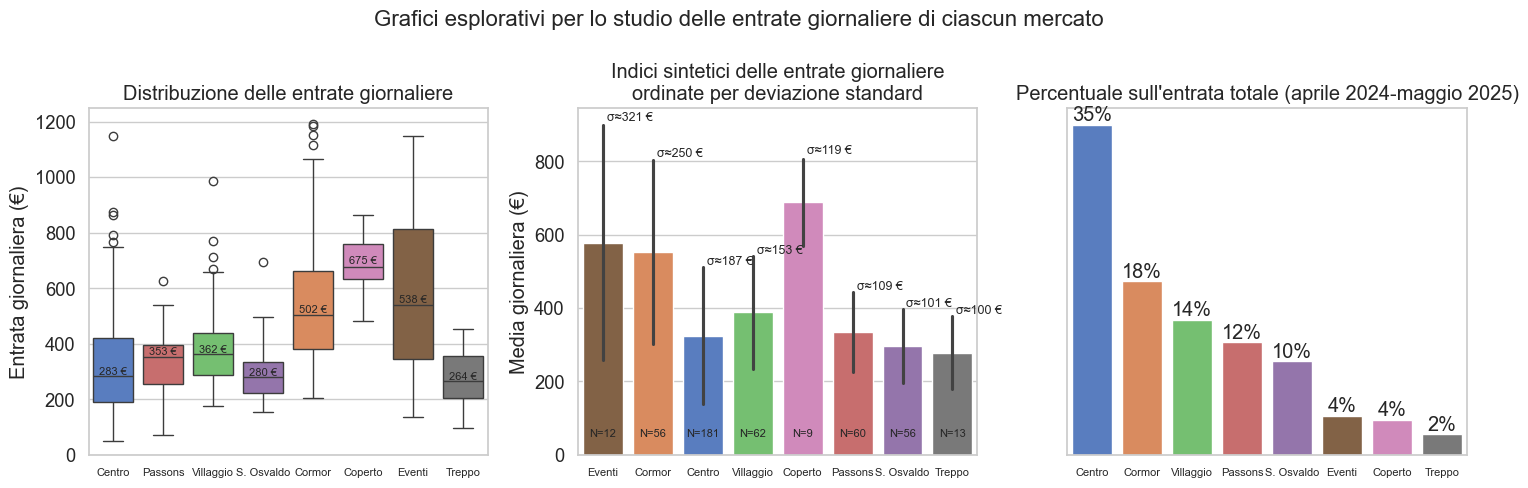

In [22]:
mercati = mercati_tot.index
mercati_palette = {key:val for key, val in zip(mercati, sns.color_palette('muted', len(mercati)))}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Grafici esplorativi per lo studio delle entrate giornaliere di ciascun mercato', fontsize=16)

# boxplot
ax_box = axes[0]
sns.boxplot(mercati_no_alv, x='Mercato', y='Totale', hue='Mercato', palette=mercati_palette, ax=ax_box)
ax_box.set_title('Distribuzione delle entrate giornaliere')
ax_box.set_ylabel('Entrata giornaliera (€)')
ax_box.set_ylim(0, None)

mediane = mercati_sintesi['50%']
v_offset = mediane * 0.02
xtick_labels = [tick.get_text() for tick in ax_box.get_xticklabels()]

for i, label in enumerate(xtick_labels):
    ax_box.text(i, mediane[label] + v_offset[label], f'{mediane[label]:.0f} €', ha='center', fontsize=8)

# indici sintetici
ax_media = axes[1]
sns.barplot(mercati_no_alv, x='Mercato', y ='Totale', hue='Mercato', errorbar='sd', order=mercati_sintesi.index, palette=mercati_palette, ax= ax_media)

ax_media.set_title('Indici sintetici delle entrate giornaliere\nordinate per deviazione standard')
ax_media.set_ylabel('Media giornaliera (€)')

# annoto la cardinalità e la std
for bar, count, std in zip(sorted(ax_media.patches, key=lambda x: x.get_x()), mercati_sintesi['count'], mercati_sintesi['std']):
    ax_media.annotate(f'N={count:.0f}', xy=(bar.get_x()+bar.get_width()/2, 50), ha='center', fontsize=8)
    ax_media.annotate(f'σ≈{std:.0f} €', xy=(bar.get_x()+bar.get_width()*1.2/2, bar.get_height()*1.02 + std), ha='left', fontsize=9)

# percentuali totali
ax_tot = axes[2]
sns.barplot(mercati_tot.iloc[:-1], x='Mercato', hue='Mercato', y='Totale %', palette=mercati_palette, ax=ax_tot)
ax_tot.set_title('Percentuale sull\'entrata totale (aprile 2024-maggio 2025)')

# annoto le percentuali
bars = ax_tot.containers
labels = [f'{val:.0f}%' for val in mercati_tot['Totale %']]
labels.pop()
for container, label in zip(bars, labels):
    ax_tot.bar_label(container, labels=[label])

ax_tot.set_ylabel('')
ax_tot.grid(False)
ax_tot.tick_params(axis='y', labelleft=False)
# impostazioni comuni
for ax in axes:
    ax.tick_params(axis='x', labelsize=8)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

È rassicurante vedere che gli outlier nella distribuzione delle entrate giornaliere sono tutti verso l'alto.

Il mercato coperto e quello di Treppo hanno meno osservazioni rispetto agli altri. Ciò è dovuto al fatto che il primo si tiene solo una volta al mese e non nei mesi estivi, il secondo, invece, è un mercato recentissimo (cominciato a marzo 2025). Ciò rende difficile, al momento, compararlo agli altri mercati periodici.

Il centro è il mercato che porta più entrate, ma ha una tra le medie più basse.

### Il mercato in centro

Questo perché il mercato in centro si tiene tre volte a settimana, il lunedì, il giovedì e il sabato.

Fino a luglio 2024, inoltre, si svolgeva anche il martedì.

Esploriamo, allora, la distribuzione interna del mercato del centro per cercare di capire come è meglio aggregare i dati.

In [23]:
mercati_centro = mercati_df[ mercati_df['Mercato'] == 'Centro'].copy()
mercati_centro_sintesi = mercati_centro.groupby('Mercato originale')['Totale'].describe()
print('Indici sintetici dei mercati del centro:')
display(mercati_centro_sintesi)

mercati_centro_tot = mercati_centro.groupby('Mercato originale').sum(numeric_only=True)
mercati_centro_tot['Totale %'] = mercati_centro_tot['Totale'] / mercati_centro_tot['Totale'].sum() * 100
print('Tavola riassuntiva dei totali dei mercati in centro:')
mercati_centro_tot

Indici sintetici dei mercati del centro:


,count,mean,std,min,25%,50%,75%,max
Mercato originale,,,,,,,,
Centro - Giovedì,52.0,247.935385,103.649219,49.68,177.9750,230.84,301.3525,599.15
Centro - Lunedì,54.0,235.668704,100.154369,50.65,177.9500,219.65,292.0000,488.92
Centro - Martedì,16.0,193.322500,91.765374,75.15,123.2775,164.86,246.0000,371.91
Centro - Sabato,59.0,509.579492,187.298333,156.80,393.3650,482.38,632.7700,1147.60


Tavola riassuntiva dei totali dei mercati in centro:


,Reparto 1,Reparto 2,Reparto 3,Reparto 4,Reparto 5,Totale,Totale %
Mercato originale,,,,,,,
Centro - Giovedì,7944.66,3848.21,468.06,631.71,0.0,12892.64,21.934801
Centro - Lunedì,7804.15,3345.81,488.32,1087.83,0.0,12726.11,21.651477
Centro - Martedì,2058.04,594.83,138.30,301.99,0.0,3093.16,5.262526
Centro - Sabato,19472.92,7503.46,1315.90,1772.91,0.0,30065.19,51.151197


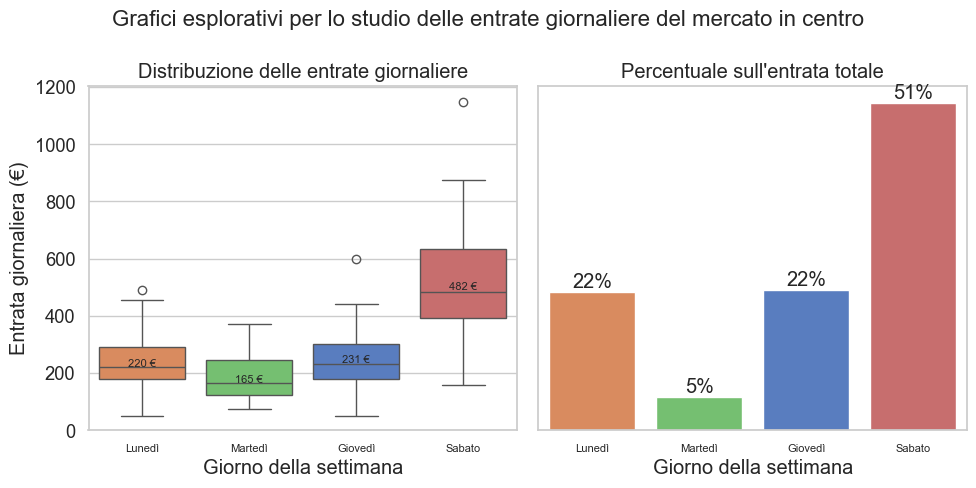

In [27]:
centro_palette = { mercato: colore for mercato, colore in zip(mercati_centro_sintesi.index, sns.color_palette('muted', len(mercati_centro_sintesi.index))) }
centro_order = ['Centro - Lunedì', 'Centro - Martedì', 'Centro - Giovedì', 'Centro - Sabato']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Grafici esplorativi per lo studio delle entrate giornaliere del mercato in centro', fontsize=16)

# boxplot
ax_box = axes[0]
sns.boxplot(mercati_centro, x='Mercato originale', y='Totale', hue='Mercato originale', order=centro_order, palette=centro_palette, ax=ax_box)
ax_box.set_title('Distribuzione delle entrate giornaliere')
ax_box.set_ylabel('Entrata giornaliera (€)')
ax_box.set_ylim(0, None)

medians = mercati_centro_sintesi['50%']
vertical_offset = medians * 0.02
xtick_labels = [tick.get_text() for tick in ax_box.get_xticklabels()]

for i, label in enumerate(xtick_labels):
    ax_box.text(i, medians[label] + vertical_offset[label], f'{medians[label]:.0f} €', ha='center', fontsize=8)

# percentuali totali
ax_tot = axes[1]
sns.barplot(mercati_centro_tot, x='Mercato originale', hue='Mercato originale', y='Totale %', palette=centro_palette, order=centro_order, ax=ax_tot)
ax_tot.set_title('Percentuale sull\'entrata totale')

# annoto le percentuali
bars = ax_tot.containers
labels = [f'{val:.0f}%' for val in mercati_centro_tot['Totale %']]
for container, label in zip(bars, labels):
    ax_tot.bar_label(container, labels=[label])

ax_tot.set_ylabel('')
ax_tot.grid(False)
ax_tot.tick_params(axis='y', labelleft=False)

# impostazioni comuni
for ax in axes:
    ax.tick_params(axis='x', labelsize=8)

# impostazioni comuni a entrambi i grafici
for ax in axes:
    ax.xaxis.set_ticks(range(4), labels=[ f"{tick.get_text().split(' ')[-1]}" for tick in ax.get_xticklabels() ])
    #ax.set_xticklabels([ f"{tick.get_text().split(' ')[-1]}" for tick in ax.get_xticklabels() ])
    ax.set_xlabel('Giorno della settimana')
#fig.text(0.525, -0.05, 'Giorno della settimana', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

Se i mercati infrasettimanali sono molto simili nella distribuzione, il mercato del sabato fa categoria a sé.

Per avere una visualizzazione più efficace, eliminiamo tutte le informazioni riguardanti il mercato del martedì e trattiamo ogni giorno come se fosse un mercato indipendente.